In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.utils import check_array
from keras.models import load_model
from keras.layers import Bidirectional
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from numpy import array
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers import Dense,LSTM,Dropout,Activation
import os
from sklearn.metrics import mean_absolute_percentage_error
from pandas import DataFrame

In [2]:
df=pd.read_csv('Delta_cases.csv')
df.head()

infection
0     341724
1     661061
2     955265
3    1228761
4    1516539

In [3]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 

In [4]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_9360/3151536076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_9360/3151536076.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [5]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [24]:
n_past = 5
n_future =7
n_features = 1

In [25]:
X_train, y_train = split_series(train.values,n_past, n_future)

In [26]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [27]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 5, 100),     40800       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  [(None, 100),        80400       ['lstm[0][0]']                   
                                 (None, 100),                                                 

In [389]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history=model.fit(X_train,y_train,epochs=100,validation_split = 0.2,batch_size=16,verbose=0)

In [11]:
model=load_model("LSTM_3days.h5")
#model=model.save("LSTM_3days.h5")

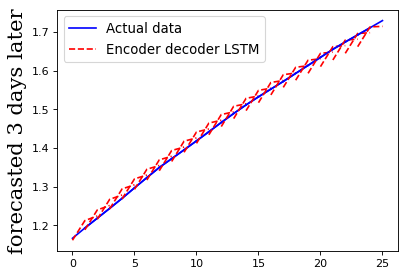

In [12]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

pred3LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}


for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3LSTM[i],"red",linestyle='dashed')
    #plt.title("Encoder decoder LSTM", fontdict = font1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
    


In [13]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.012262617959952482
Day  2 :
MAE-E2D2 :  0.016942925992543118
Day  3 :
MAE-E2D2 :  0.006324099104605334


mean 0.011843214352366979


In [13]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.7983063251147812
Day  2 :
MAE-E2D2 :  1.2070371250140461
Day  3 :
MAE-E2D2 :  0.42727359927347874


mean 0.8108723498007687


In [14]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   



infection
Day  1 :
MAE-E2D2 :  0.015024509367538266
Day  2 :
MAE-E2D2 :  0.018144087814725738
Day  3 :
MAE-E2D2 :  0.007230265633811212


mean 0.013466287605358404


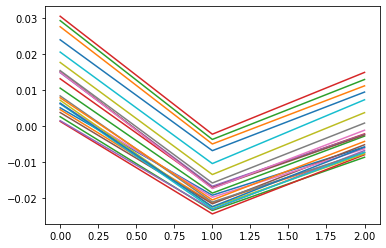

In [14]:
#residual plot

residuals = y_test-pred3LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    


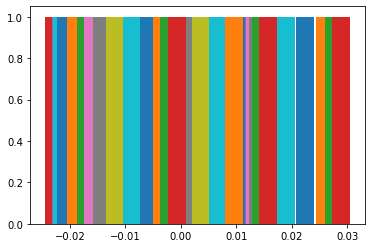

In [16]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

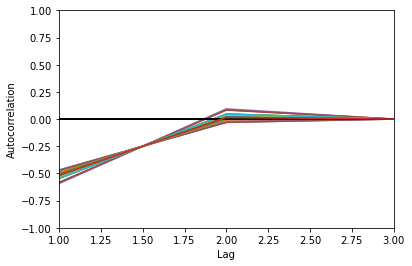

In [17]:
from pandas.plotting import autocorrelation_plot
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

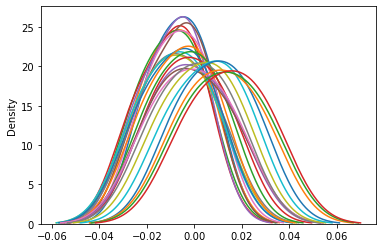

In [15]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [19]:
model=load_model("LSTM_5days.h5")
#model=model.save("LSTM_5days.h5")

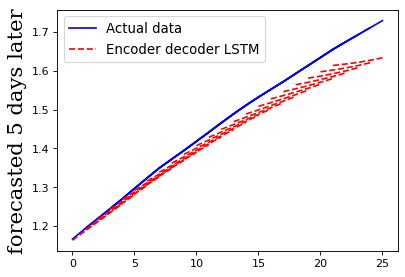

In [20]:
pred5LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"red",linestyle='dashed')
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    #plt.xlabel("days")   
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)


In [21]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.0159032252023953
Day  2 :
MAE-E2D2 :  0.02516799958910791
Day  3 :
MAE-E2D2 :  0.0338818715801632
Day  4 :
MAE-E2D2 :  0.04165351509204227
Day  5 :
MAE-E2D2 :  0.048567613179674216


mean 0.033034844928676574


In [24]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  1.046110903796896
Day  2 :
MAE-E2D2 :  1.6510771232867303
Day  3 :
MAE-E2D2 :  2.203193927702131
Day  4 :
MAE-E2D2 :  2.678667534704711
Day  5 :
MAE-E2D2 :  3.0870478648495037


mean 2.133219470867995


In [25]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


infection
Day  1 :
MAE-E2D2 :  0.01983520723361536
Day  2 :
MAE-E2D2 :  0.02964461473854271
Day  3 :
MAE-E2D2 :  0.03890214849643601
Day  4 :
MAE-E2D2 :  0.04721250765411009
Day  5 :
MAE-E2D2 :  0.05459314511661603


mean 0.03803752464786404


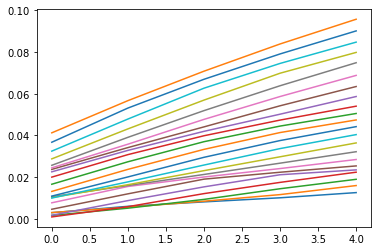

In [22]:
#residual plot

residuals = y_test-pred5LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

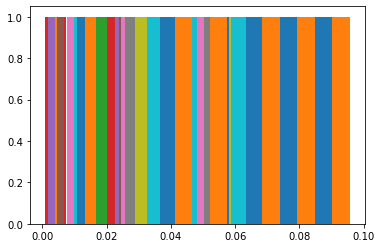

In [27]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

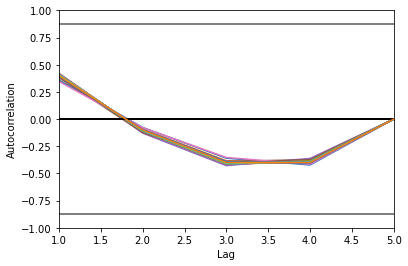

In [28]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

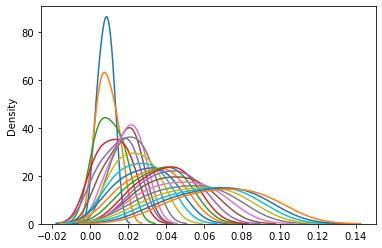

In [23]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [28]:
model=load_model("LSTM_7days.h5")
#model=model.save("LSTM_7days.h5")

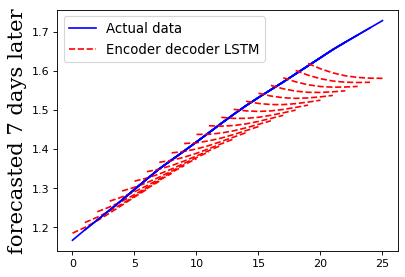

In [29]:
pred7LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)


In [30]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  0.016110349582256746
Day  2 :
MAE-E2D2 :  0.009878853825745692
Day  3 :
MAE-E2D2 :  0.025557383671078404
Day  4 :
MAE-E2D2 :  0.04206420413475054
Day  5 :
MAE-E2D2 :  0.0561794134723048
Day  6 :
MAE-E2D2 :  0.06878913686483112
Day  7 :
MAE-E2D2 :  0.08069822185045564


mean 0.04275393762877471


In [35]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  1.1899707875758867
Day  2 :
MAE-E2D2 :  0.6624524385957392
Day  3 :
MAE-E2D2 :  1.6709775317626467
Day  4 :
MAE-E2D2 :  2.7428199530784036
Day  5 :
MAE-E2D2 :  3.626951570077201
Day  6 :
MAE-E2D2 :  4.3907218631051075
Day  7 :
MAE-E2D2 :  5.091193087618849


mean 2.7678696045448334


In [36]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


infection
Day  1 :
MAE-E2D2 :  0.016814998629551756
Day  2 :
MAE-E2D2 :  0.012663150461265774
Day  3 :
MAE-E2D2 :  0.030956307118626243
Day  4 :
MAE-E2D2 :  0.04816510573055034
Day  5 :
MAE-E2D2 :  0.06310979449746991
Day  6 :
MAE-E2D2 :  0.07645963611623718
Day  7 :
MAE-E2D2 :  0.08899286517446688


mean 0.04816597967545259


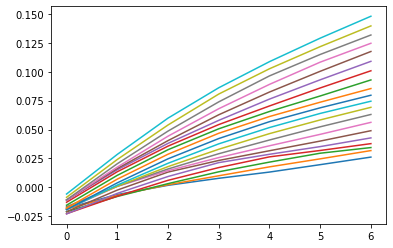

In [37]:
#residual plot

residuals = y_test-pred7LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

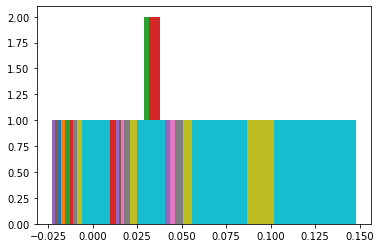

In [38]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

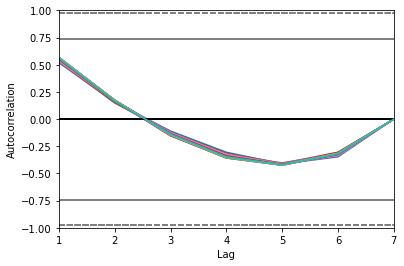

In [39]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

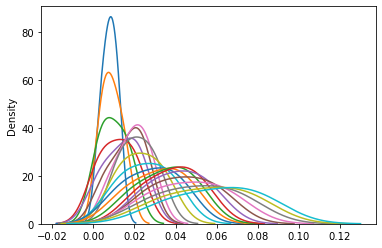

In [31]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [ ]:
#BiLSTM

In [40]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_8996/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_8996/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [41]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [68]:
n_past = 5
n_future =7
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [69]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [36]:
#define model
model = Sequential()
model.add(Bidirectional(LSTM(150, return_sequences=True), input_shape=(n_past, n_features)))
model.add(Bidirectional(LSTM(128,activation='relu')))
model.add(Dense(128))
model.add(Dense(n_future))
model.compile(loss='mean_squared_error', optimizer='Adam')

In [449]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 16)

Epoch 1/100
4/4 [==============================] - 11s 776ms/step - loss: 0.1583 - val_loss: 0.4260
Epoch 2/100
4/4 [==============================] - 0s 81ms/step - loss: 0.0681 - val_loss: 0.3298
Epoch 3/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0371 - val_loss: 0.1982
Epoch 4/100
4/4 [==============================] - 0s 80ms/step - loss: 0.0136 - val_loss: 0.0730
Epoch 5/100
4/4 [==============================] - 0s 79ms/step - loss: 0.0123 - val_loss: 0.0117
Epoch 6/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0044 - val_loss: 0.0262
Epoch 7/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 8/100
4/4 [==============================] - 0s 79ms/step - loss: 0.0019 - val_loss: 0.0350
Epoch 9/100
4/4 [==============================] - 0s 81ms/step - loss: 0.0037 - val_loss: 0.0340
Epoch 10/100
4/4 [==============================] - 0s 83ms/step - loss: 0.0012 - val_loss: 0.0133
Epoch 11/100
4/4 

4/4 [==============================] - 0s 90ms/step - loss: 9.8912e-06 - val_loss: 0.0014
Epoch 81/100
4/4 [==============================] - 0s 77ms/step - loss: 1.0423e-05 - val_loss: 0.0012
Epoch 82/100
4/4 [==============================] - 0s 73ms/step - loss: 9.4727e-06 - val_loss: 0.0012
Epoch 83/100
4/4 [==============================] - 0s 77ms/step - loss: 9.3054e-06 - val_loss: 0.0013
Epoch 84/100
4/4 [==============================] - 0s 79ms/step - loss: 9.2894e-06 - val_loss: 0.0012
Epoch 85/100
4/4 [==============================] - 0s 75ms/step - loss: 9.2671e-06 - val_loss: 0.0013
Epoch 86/100
4/4 [==============================] - 0s 76ms/step - loss: 9.1588e-06 - val_loss: 0.0013
Epoch 87/100
4/4 [==============================] - 0s 77ms/step - loss: 9.0942e-06 - val_loss: 0.0013
Epoch 88/100
4/4 [==============================] - 0s 77ms/step - loss: 9.3280e-06 - val_loss: 0.0012
Epoch 89/100
4/4 [==============================] - 0s 75ms/step - loss: 9.2260e-06 - 

In [51]:
#model.save('bilstm_3days.h5')
model=load_model("bilstm_3days.h5")

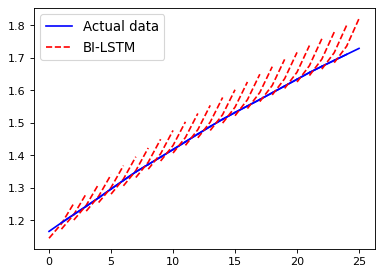

In [52]:
pred3BiLSTM=model.predict(X_test)
pred3BiLSTM = pred3BiLSTM.reshape((pred3BiLSTM.shape[0], pred3BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
      

In [53]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  0.012138362143810718
Day  2 :
MAE-E2D2 :  0.013501003456747077
Day  3 :
MAE-E2D2 :  0.06564480355298603


mean 0.03042805638451461


In [54]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  0.881634687022854
Day  2 :
MAE-E2D2 :  0.8728204639473355
Day  3 :
MAE-E2D2 :  4.330272677798497


mean 2.028242609589562


In [48]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.012838972250581544
Day  2 :
MAE-E2D2 :  0.015660849478363197
Day  3 :
MAE-E2D2 :  0.06792338195390271


mean 0.032141067894282484


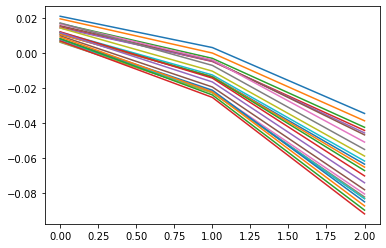

In [55]:
#residual plot

residuals = y_test-pred3BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

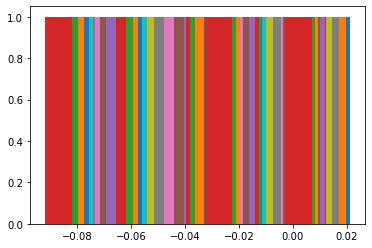

In [56]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

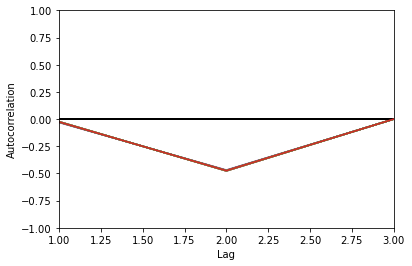

In [57]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)    
    
    

In [60]:
#model.save('bilstm_5days.h5')
model=load_model("bilstm_5days.h5")

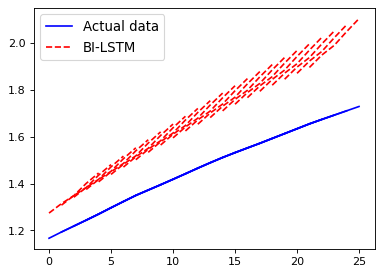

In [61]:
pred5BiLSTM=model.predict(X_test)
pred5BiLSTM= pred5BiLSTM.reshape((pred5BiLSTM.shape[0], pred5BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
      

In [62]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.17763929861518726
Day  2 :
MAE-E2D2 :  0.20142617757028816
Day  3 :
MAE-E2D2 :  0.21642915629348292
Day  4 :
MAE-E2D2 :  0.2501949060047595
Day  5 :
MAE-E2D2 :  0.2787564792084789


mean 0.22488920353843933


In [63]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  12.315495158832029
Day  2 :
MAE-E2D2 :  13.738729054500196
Day  3 :
MAE-E2D2 :  14.528926551041494
Day  4 :
MAE-E2D2 :  16.5700528643718
Day  5 :
MAE-E2D2 :  18.197475508437595


mean 15.070135827436621


In [64]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.1822789841687441
Day  2 :
MAE-E2D2 :  0.2068272418315587
Day  3 :
MAE-E2D2 :  0.22246537001560107
Day  4 :
MAE-E2D2 :  0.25633504612664665
Day  5 :
MAE-E2D2 :  0.28549164577452135


mean 0.23067965758341438


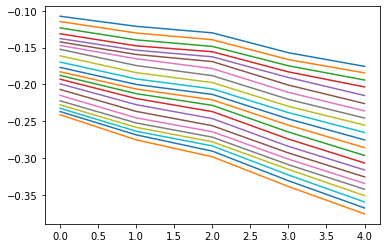

In [65]:
#residual plot

residuals = y_test-pred5BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

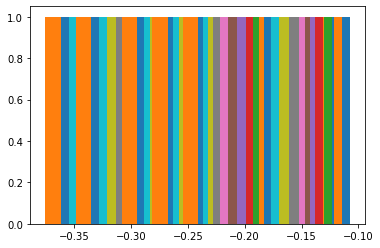

In [66]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

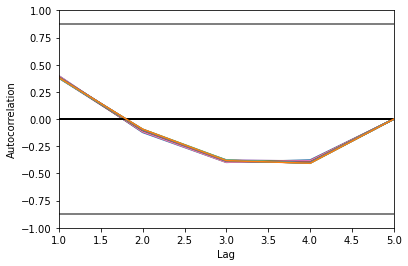

In [67]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)   

In [70]:
#model.save('bilstm_7days.h5')
model=load_model("bilstm_7days.h5")

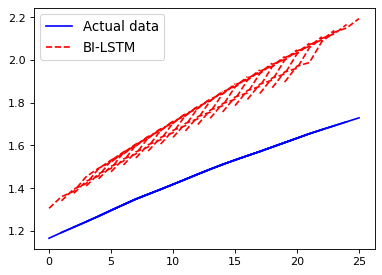

In [71]:
pred7BiLSTM=model.predict(X_test)
pred7BiLSTM = pred7BiLSTM.reshape((pred7BiLSTM.shape[0], pred7BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
#plt.legend()       

In [72]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.21345028369289826
Day  2 :
MAE-E2D2 :  0.2549022781960161
Day  3 :
MAE-E2D2 :  0.2531219276044038
Day  4 :
MAE-E2D2 :  0.31385153301734914
Day  5 :
MAE-E2D2 :  0.33308573039900263
Day  6 :
MAE-E2D2 :  0.3353751118400791
Day  7 :
MAE-E2D2 :  0.35914704806798614


mean 0.2947048446882479


In [73]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  15.078461754451814
Day  2 :
MAE-E2D2 :  17.71142202655392
Day  3 :
MAE-E2D2 :  17.309300486561085
Day  4 :
MAE-E2D2 :  21.13763782785047
Day  5 :
MAE-E2D2 :  22.09925996736455
Day  6 :
MAE-E2D2 :  21.931893903955046
Day  7 :
MAE-E2D2 :  23.17378950618271


mean 19.777395067559944


In [74]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    



infection
Day  1 :
MAE-E2D2 :  0.21777046379336726
Day  2 :
MAE-E2D2 :  0.2600705757872452
Day  3 :
MAE-E2D2 :  0.25820905732723365
Day  4 :
MAE-E2D2 :  0.31994705451851885
Day  5 :
MAE-E2D2 :  0.3394940493627971
Day  6 :
MAE-E2D2 :  0.34172347544184306
Day  7 :
MAE-E2D2 :  0.36538176664741095


mean 0.3003709204112023


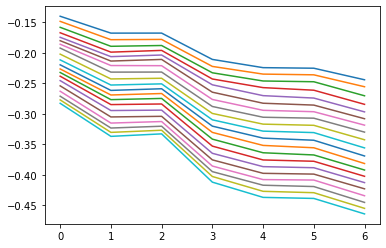

In [75]:
#residual plot

residuals = y_test-pred7BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

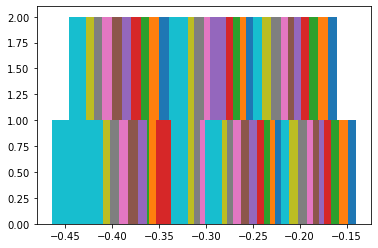

In [76]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

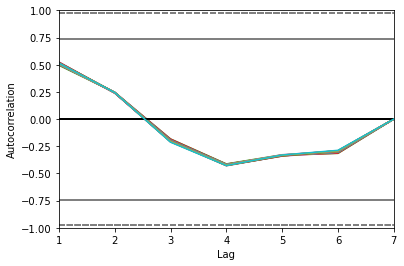

In [77]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [ ]:
#ConvLSTM

In [10]:
n_past=4
n_future=7
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):]
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s
    
    
    
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y) 


X_train, y_train = split_series(train.values,n_past, n_future)
X_test, y_test = split_series(test.values,n_past, n_future)

n_features = 1
n_seq = 2
n_steps = 2
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_10140/427068468.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_10140/427068468.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [485]:
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')

In [486]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False)

Epoch 1/100
5/5 [==============================] - 6s 140ms/step - loss: 0.1997 - val_loss: 0.4811
Epoch 2/100
5/5 [==============================] - 0s 24ms/step - loss: 0.1924 - val_loss: 0.4759
Epoch 3/100
5/5 [==============================] - 0s 28ms/step - loss: 0.1868 - val_loss: 0.4697
Epoch 4/100
5/5 [==============================] - 0s 25ms/step - loss: 0.1815 - val_loss: 0.4632
Epoch 5/100
5/5 [==============================] - 0s 29ms/step - loss: 0.1762 - val_loss: 0.4560
Epoch 6/100
5/5 [==============================] - 0s 22ms/step - loss: 0.1708 - val_loss: 0.4481
Epoch 7/100
5/5 [==============================] - 0s 23ms/step - loss: 0.1652 - val_loss: 0.4394
Epoch 8/100
5/5 [==============================] - 0s 29ms/step - loss: 0.1594 - val_loss: 0.4298
Epoch 9/100
5/5 [==============================] - 0s 27ms/step - loss: 0.1533 - val_loss: 0.4191
Epoch 10/100
5/5 [==============================] - 0s 26ms/step - loss: 0.1467 - val_loss: 0.4071
Epoch 11/100
5/5 [

Epoch 82/100
5/5 [==============================] - 0s 24ms/step - loss: 8.7208e-05 - val_loss: 0.0025
Epoch 83/100
5/5 [==============================] - 0s 23ms/step - loss: 8.5245e-05 - val_loss: 0.0025
Epoch 84/100
5/5 [==============================] - 0s 25ms/step - loss: 8.3291e-05 - val_loss: 0.0025
Epoch 85/100
5/5 [==============================] - 0s 25ms/step - loss: 8.1369e-05 - val_loss: 0.0025
Epoch 86/100
5/5 [==============================] - 0s 24ms/step - loss: 7.9504e-05 - val_loss: 0.0025
Epoch 87/100
5/5 [==============================] - 0s 23ms/step - loss: 7.7695e-05 - val_loss: 0.0025
Epoch 88/100
5/5 [==============================] - 0s 23ms/step - loss: 7.5925e-05 - val_loss: 0.0025
Epoch 89/100
5/5 [==============================] - 0s 25ms/step - loss: 7.4213e-05 - val_loss: 0.0025
Epoch 90/100
5/5 [==============================] - 0s 22ms/step - loss: 7.2555e-05 - val_loss: 0.0025
Epoch 91/100
5/5 [==============================] - 0s 23ms/step - loss: 

In [79]:
#model.save('ConvLSTM_3days.h5')
model=load_model("ConvLSTM_3days.h5")

In [80]:
pred3ConvLSTM=model.predict(X_test)

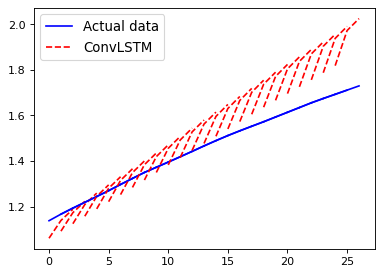

In [81]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [82]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3ConvLSTM = pred3ConvLSTM.reshape((pred3ConvLSTM.shape[0], pred3ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

infection
Day  1 :
MAE-E2D2 :  0.05383073122372865
Day  2 :
MAE-E2D2 :  0.10808409731469118
Day  3 :
MAE-E2D2 :  0.13321766536823906


mean 0.09837749796888628


In [83]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  

infection
Day  1 :
MAE-E2D2 :  3.7446745691717487
Day  2 :
MAE-E2D2 :  6.902069963291513
Day  3 :
MAE-E2D2 :  8.446489952473012


mean 6.364411494978758


In [84]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    




infection
Day  1 :
MAE-E2D2 :  0.06307114104883592
Day  2 :
MAE-E2D2 :  0.13565764177368936
Day  3 :
MAE-E2D2 :  0.16108601347005644


mean 0.11993826543086057


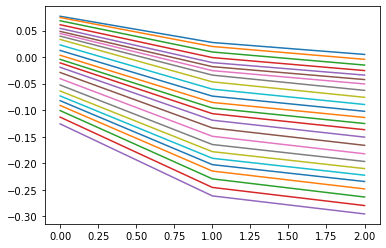

In [85]:
#residual plot

residuals = y_test-pred3ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

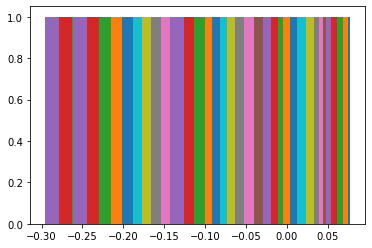

In [86]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

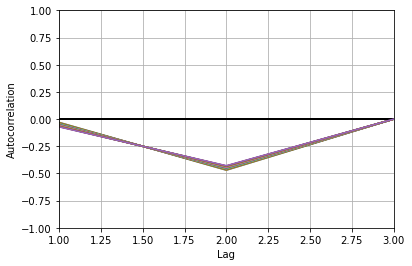

In [87]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [5]:
#model.save('ConvLSTM_5days.h5')
model=load_model("ConvLSTM_5days.h5")

In [6]:
pred5ConvLSTM=model.predict(X_test)

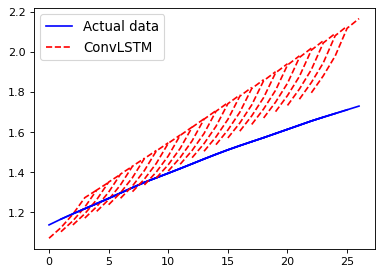

In [7]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [8]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5ConvLSTM = pred5ConvLSTM.reshape((pred5ConvLSTM.shape[0], pred5ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

infection
Day  1 :
MAE-E2D2 :  0.057523294878743185
Day  2 :
MAE-E2D2 :  0.08212295926878843
Day  3 :
MAE-E2D2 :  0.13252570575511924
Day  4 :
MAE-E2D2 :  0.22020512198877376
Day  5 :
MAE-E2D2 :  0.24085262060373297


mean 0.1466459404990315


In [9]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    
     

infection
Day  1 :
MAE-E2D2 :  3.958714739463404
Day  2 :
MAE-E2D2 :  5.3570961560180335
Day  3 :
MAE-E2D2 :  8.562824373570264
Day  4 :
MAE-E2D2 :  14.298159521332753
Day  5 :
MAE-E2D2 :  15.451559073505727


mean 9.525670772778035


In [95]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.06939798572430472
Day  2 :
MAE-E2D2 :  0.10446061366240766
Day  3 :
MAE-E2D2 :  0.15909033488827182
Day  4 :
MAE-E2D2 :  0.24506841425440973
Day  5 :
MAE-E2D2 :  0.2661358294941109


mean 0.16883063560470096


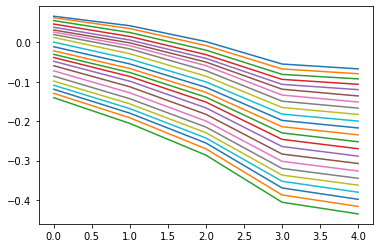

In [96]:
#residual plot

residuals = y_test-pred5ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

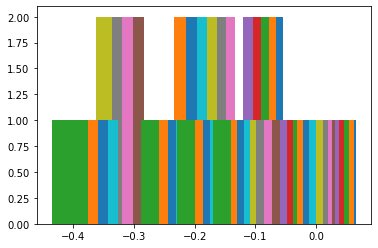

In [97]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

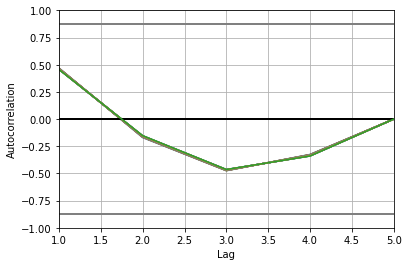

In [98]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [11]:
#model.save('ConvLSTM_7days.h5')
model=load_model("ConvLSTM_7days.h5")

In [12]:
pred7ConvLSTM=model.predict(X_test)

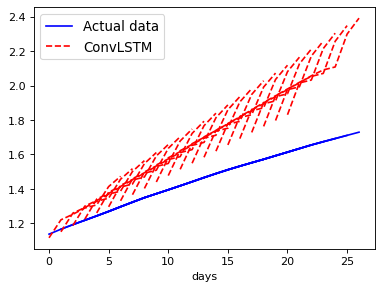

In [13]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"red",linestyle='dashed')
    plt.xlabel("days")   
    #plt.ylabel("forecasted 7 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [14]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7ConvLSTM = pred7ConvLSTM.reshape((pred7ConvLSTM.shape[0], pred7ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

infection
Day  1 :
MAE-E2D2 :  0.09121267067124018
Day  2 :
MAE-E2D2 :  0.20831108508350565
Day  3 :
MAE-E2D2 :  0.22118827151771545
Day  4 :
MAE-E2D2 :  0.23427388858263287
Day  5 :
MAE-E2D2 :  0.22903498139118966
Day  6 :
MAE-E2D2 :  0.35469934494743843
Day  7 :
MAE-E2D2 :  0.4086961814477088


mean 0.24963091766306159


In [15]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  6.14154105896966
Day  2 :
MAE-E2D2 :  14.182240167463181
Day  3 :
MAE-E2D2 :  14.83922679446496
Day  4 :
MAE-E2D2 :  15.51467106324534
Day  5 :
MAE-E2D2 :  14.922541735288547
Day  6 :
MAE-E2D2 :  22.974316966589907
Day  7 :
MAE-E2D2 :  26.15597408726


mean 16.39007312475451


In [105]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.11399756544682604
Day  2 :
MAE-E2D2 :  0.23117484238845643
Day  3 :
MAE-E2D2 :  0.24480637129614377
Day  4 :
MAE-E2D2 :  0.25731499630280086
Day  5 :
MAE-E2D2 :  0.2533810041453022
Day  6 :
MAE-E2D2 :  0.38008050323491976
Day  7 :
MAE-E2D2 :  0.43497283563432304


mean 0.2736754454926817


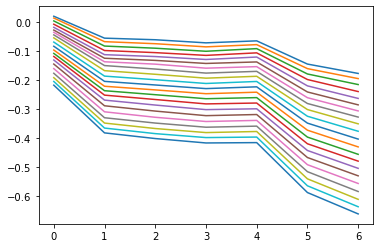

In [106]:
#residual plot

residuals = y_test-pred7ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

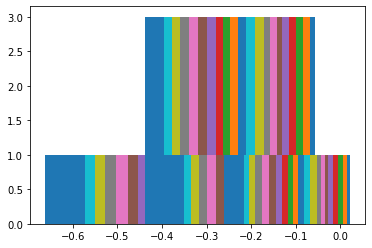

In [107]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

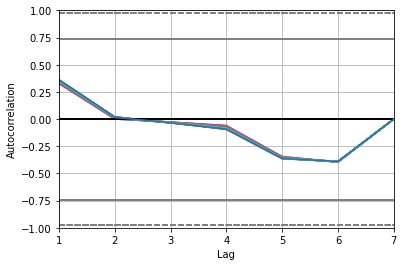

In [108]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [ ]:
#GRU

In [16]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_10140/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_10140/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [17]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [34]:
n_past = 5
n_future =7
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [35]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

In [27]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (83, 5, 1)
y_train.shape:  (83, 5)
X_test.shape:  (22, 5, 1)
y_test.shape:  (22, 5)


In [70]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = n_future)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [553]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        )
    return history
history_gru = fit_model(model_gru)


Epoch 1/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0024 - val_loss: 1.8827e-04
Epoch 2/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 3/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 4/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 5/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0020 - val_loss: 5.3653e-04
Epoch 6/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 7/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0028 - val_loss: 6.6878e-04
Epoch 8/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 9/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0018 - val_loss: 6.6887e-04
Epoch 10/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0018 - val_loss: 0.0015
Epo

In [20]:
#model_gru.save('GRU_3days.h5')
model_gru=load_model("GRU_3days.h5")

In [21]:
pred3GRU=model_gru.predict(X_test)

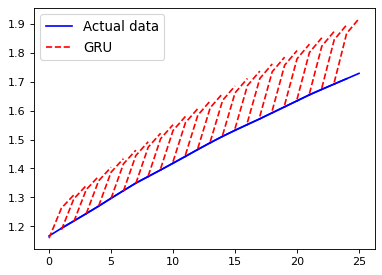

In [22]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','GRU'],fontsize=12)


In [23]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3GRU = pred3GRU.reshape((pred3GRU.shape[0], pred3GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

infection
Day  1 :
MAE-E2D2 :  0.004267581804445031
Day  2 :
MAE-E2D2 :  0.11838428451909087
Day  3 :
MAE-E2D2 :  0.14504593899762716


mean 0.08923260177372101


In [24]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.2908740222934814
Day  2 :
MAE-E2D2 :  7.968071882717568
Day  3 :
MAE-E2D2 :  9.62809925439535


mean 5.9623483864688


In [118]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.004876173417522414
Day  2 :
MAE-E2D2 :  0.12117313950868296
Day  3 :
MAE-E2D2 :  0.14812725152121944


mean 0.09139218814914159


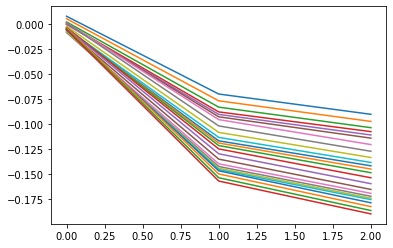

In [119]:
#residual plot

residuals = y_test-pred3GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

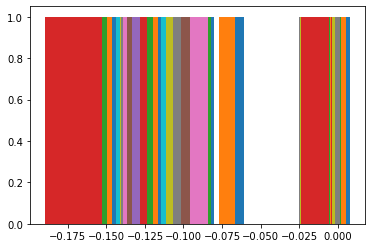

In [120]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

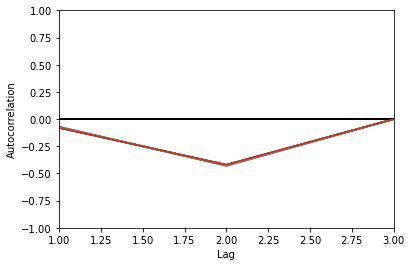

In [121]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [28]:
#model_gru.save('GRU_5days.h5')
model_gru=load_model("GRU_5days.h5")

In [29]:
pred5GRU=model_gru.predict(X_test)


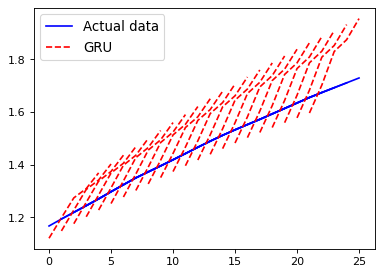

In [30]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','GRU'],fontsize=12)


In [31]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5GRU = pred5GRU.reshape((pred5GRU.shape[0], pred5GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

infection
Day  1 :
MAE-E2D2 :  0.04826706261791709
Day  2 :
MAE-E2D2 :  0.02185537262755025
Day  3 :
MAE-E2D2 :  0.10140355468971483
Day  4 :
MAE-E2D2 :  0.1199310626851267
Day  5 :
MAE-E2D2 :  0.16793210557310012


mean 0.0918778316386818


In [33]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


infection
Day  1 :
MAE-E2D2 :  3.4031744327206965
Day  2 :
MAE-E2D2 :  1.474116938452505
Day  3 :
MAE-E2D2 :  6.797294856068681
Day  4 :
MAE-E2D2 :  7.915813971195972
Day  5 :
MAE-E2D2 :  10.947779466281574


mean 6.107635932943886


In [129]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.04845809864506811
Day  2 :
MAE-E2D2 :  0.023151411048851402
Day  3 :
MAE-E2D2 :  0.10455379430596752
Day  4 :
MAE-E2D2 :  0.12381492335183755
Day  5 :
MAE-E2D2 :  0.17249854941210357


mean 0.09449535535276563


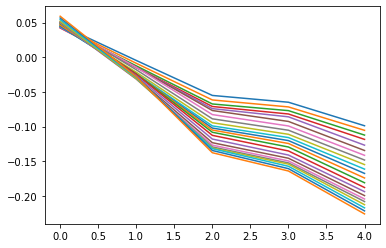

In [130]:
#residual plot

residuals = y_test-pred5GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

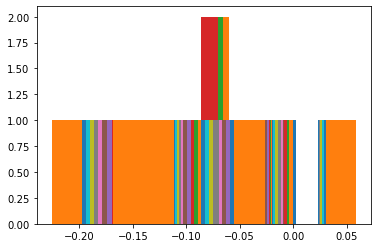

In [131]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

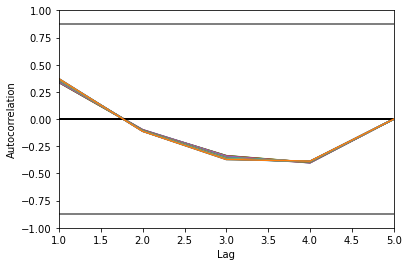

In [132]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [36]:
#model_gru.save('GRU_7days.h5')
model_gru=load_model("GRU_7days.h5")

In [37]:
pred7GRU=model_gru.predict(X_test)


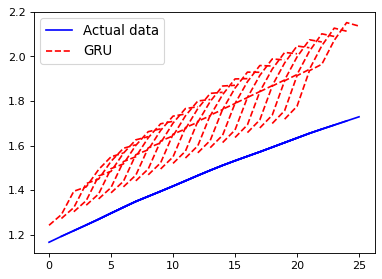

In [38]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7days later") 
    plt.legend(['Actual data','GRU'],fontsize=12)

In [39]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7GRU = pred7GRU.reshape((pred7GRU.shape[0], pred7GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

infection
Day  1 :
MAE-E2D2 :  0.09666646211010403
Day  2 :
MAE-E2D2 :  0.12712096453825544
Day  3 :
MAE-E2D2 :  0.23672525011035467
Day  4 :
MAE-E2D2 :  0.23820475705642688
Day  5 :
MAE-E2D2 :  0.3092932549370428
Day  6 :
MAE-E2D2 :  0.3565269644478062
Day  7 :
MAE-E2D2 :  0.33654166467183744


mean 0.2430113311245468


In [41]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


infection
Day  1 :
MAE-E2D2 :  6.905785611253293
Day  2 :
MAE-E2D2 :  8.913529439762465
Day  3 :
MAE-E2D2 :  16.285068999501025
Day  4 :
MAE-E2D2 :  16.101585314322538
Day  5 :
MAE-E2D2 :  20.591306382756148
Day  6 :
MAE-E2D2 :  23.379701410717185
Day  7 :
MAE-E2D2 :  21.782543701719113


mean 16.279931551433112


In [140]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.0970740211471519
Day  2 :
MAE-E2D2 :  0.1278714412915172
Day  3 :
MAE-E2D2 :  0.23894572319294896
Day  4 :
MAE-E2D2 :  0.24113026158267226
Day  5 :
MAE-E2D2 :  0.3131030968844657
Day  6 :
MAE-E2D2 :  0.36120157267949005
Day  7 :
MAE-E2D2 :  0.34026376030915956


mean 0.24565569672677223


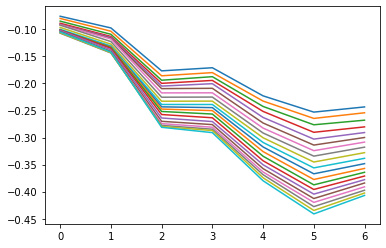

In [141]:
#residual plot

residuals = y_test-pred7GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

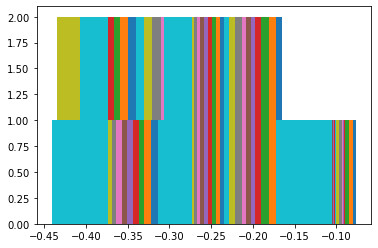

In [142]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

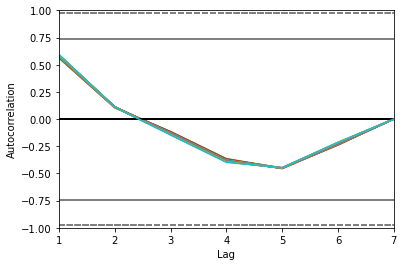

In [143]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

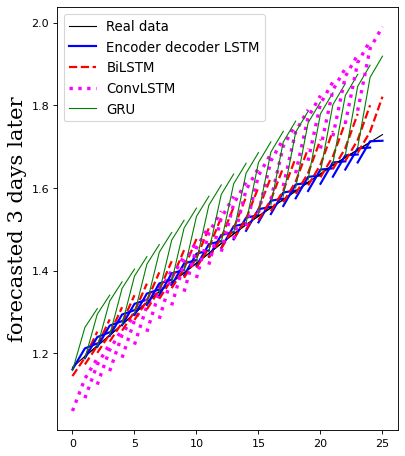

In [129]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)
font1 = {'family':'Serif','color':'black','size':19}
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black",linewidth=1)
    plt.plot(range(i,i+n_future),pred3LSTM[i],"blue",linestyle='solid',linewidth=1.95)
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dashed',linewidth=2)
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"magenta",linestyle='dotted',linewidth=3)
    plt.plot(range(i,i+n_future),pred3GRU[i],"green",linestyle='solid',linewidth=1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()

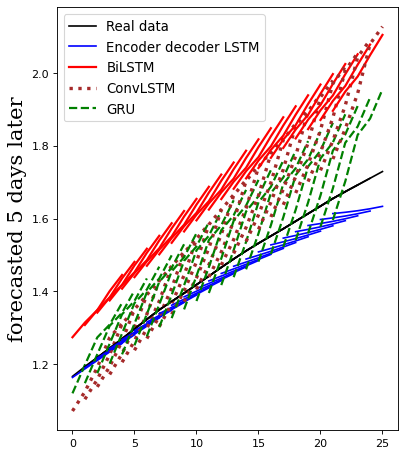

In [120]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"blue",linestyle='solid')
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='solid',linewidth=2)
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"brown",linestyle='dotted',linewidth=3)
    plt.plot(range(i,i+n_future),pred5GRU[i],"green",linestyle='dashed',linewidth=2)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()

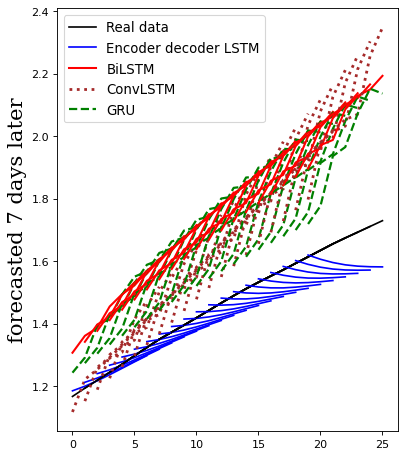

In [112]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"blue",linestyle='solid')
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='solid',linewidth=1.85)
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"brown",linestyle='dotted',linewidth=2.5)
    plt.plot(range(i,i+n_future),pred7GRU[i],"green",linestyle='dashed',linewidth=2)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()